In [1]:
from utils import utils
from utils import scale_by_scale_optim
from utils import agent_based_simulation_on_grid
import random
import numpy as np
import time
%pylab inline
prop_cycle = plt.rcParams['axes.prop_cycle']


Populating the interactive namespace from numpy and matplotlib


/home/laura/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Simulation example

In [2]:
### Generate parameters
L = 3
comb = [random.randint(20,100) for i in range(L)]
c0 = random.random()*2
c1 = random.random()*2
d = random.random()*2

### Run simulation
model = agent_based_simulation_on_grid.ContainerModel(comb, c0, c1, d)
model.run_simulation(1000)
x,y= zip(*model.positions)


In [3]:

### Visualize
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()

#Colors of transitions
colors = [i['color'] for i in list(prop_cycle)]
transitions = utils.get_scale_labels(model.positions_scales)

tools = "wheel_zoom, pan"
p = figure(tools=tools)
p.scatter(x,y, alpha=0.5, color = 'black')

xs = [[i,i2] for (i,i2) in zip(x[:-1],x[1:])]
ys = [[j,j2] for (j,j2) in zip(y[:-1],y[1:])]

p.multi_line(xs,ys, alpha=0.5, color = [colors[i-1] for i in transitions])
show(p)

Loading BokehJS ...

# Evaluate fitting routine

In [4]:

def simulate_fit_evaluate():
    random.seed(int(time.time()))
    
    
    #######################
    #### Simulate   #######
    #######################
    
    #Generate parameters
    L = 3
    comb = [random.randint(20,100) for i in range(L)]
    c0 = random.random()*2
    c1 = random.random()*2
    d = random.random()*2
    
    #Run simulation
    model = agent_based_simulation_on_grid.ContainerModel(comb, c0, c1, d)
    model.run_simulation(1000)
    x,y= zip(*model.positions)

    #######################
    ####    Fit     #######
    #######################
    
    stop_locations = np.unique(model.positions, axis = 0)
    locs  = dict(zip([tuple(i) for i in stop_locations], range(len(stop_locations))))
    labels = [locs[i] for i in model.positions]
    optimization = scale_by_scale_optim.ScalesOptim(labels, stop_locations,  verbose = False, distance_func=utils.euclidean, bootstrap = True)
    res = optimization.find_best_scale()
    
    alphas = np.median(list(res[-1].values()),axis = 0)
    
    #######################
    #### Evaluate   #######
    #######################
    
    #Compute correlation
    corr = utils.cophenetic_correlation(model.positions_scales, res[0])
    
    #Compute number of scales
    n_s = len(res[0][0]) - L
    
    #Compute difference in p
    if (len(alphas)-1)==len(model.bernullis):
        diff = np.abs(alphas[:-1] - model.bernullis)
    else:
        diff = np.nan
    return(corr, n_s, diff)



In [5]:
from joblib import Parallel, delayed
res4 = Parallel(n_jobs=2)(delayed(simulate_fit_evaluate)() for i in range(100))
corr, n_s, diff = zip(*res4)

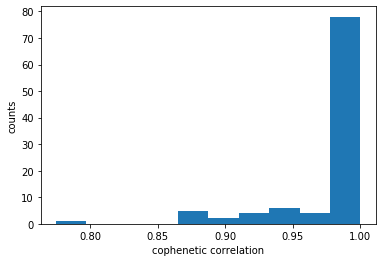

In [21]:
#Cophenetic correlation
plt.figure()
plt.hist([i[0] for i in corr])
plt.xlabel('cophenetic correlation')
plt.ylabel('counts')
plt.show()

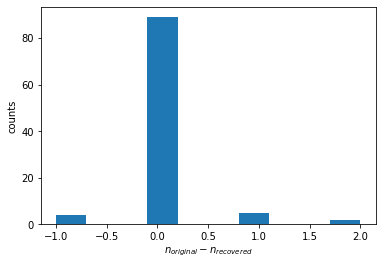

In [23]:
#Number of levels
plt.figure()
plt.hist([i for i in n_s])
plt.xlabel(r'$n_{original} - n_{recovered}$')
plt.ylabel('counts')
plt.show()

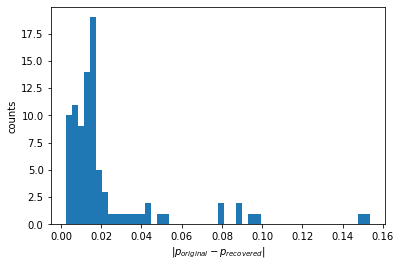

In [24]:
#absolute distance between p recovered and p original
plt.figure()
plt.hist([i.mean() for i in diff if not type(i)==np.float], bins = 50)
plt.xlabel(r'$|p_{original} - p_{recovered}$|')
plt.ylabel('counts')

plt.show()